In [2]:
import jax
import os
os.environ["CUDA_VISIBLE_DEVICES"]="4"
jax.config.update('jax_enable_x64',True)

from jax.random import key
from scipy.integrate import solve_ivp
from tqdm.auto import tqdm
from exp.expdata import LorenzExp
import jax.numpy as jnp
import matplotlib.pyplot as plt
from exp.metrics import coeff_metrics, data_metrics
plt.style.use("ggplot")

from jsindy.sindy_model import JSINDyModel
from jsindy.util import get_collocation_points_weights
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ,SSR,MIOSR
from jsindy.kernels import ConstantKernel, ScalarMaternKernel
import pickle
from pathlib import Path


In [3]:
x0 = jnp.array([-8, 8, 27.])
dt = 0.01
t0=0
t1=10.1
n_colloc = 505

expdata = LorenzExp(
    dt = dt,
    initial_state=x0,
    feature_names=['x','y','z'],
    t0=t0,
    t1=t1,
    n_colloc=n_colloc
)

tEndL = jnp.arange(4.0, 11.0, 1.0)
epsL = jnp.arange(0.025, 0.401, 0.025)

t_true = expdata.t_true
X_true = expdata.x_true

cutoff = 1
signal_power = jnp.std(X_true)
n_colloc = 500


In [ ]:
tend = 5
noise_ratio = 0.1
rkey = jax.random.key(12038)
t_end_idx = int(tend // dt)
X_train = X_true[:t_end_idx]
t_train = t_true[:t_end_idx]

t_colloc, w_colloc = get_collocation_points_weights(t_train,n_colloc)

eps = noise_ratio*signal_power


noise = eps*jax.random.normal(rkey, X_train.shape)

X_train = X_train + noise

kernel = (
	ConstantKernel(variance = 5.)
	+ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   
trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
	reg_scaling = 1.,
	feature_map=PolyLib(degree=2)
)
optsettings = LMSettings(
	max_iter = 1000,
	no_tqdm=True,
	min_alpha = 1e-16,
	init_alpha = 5.,
	print_every = 100,
	show_progress = True,
)
data_weight =  1.
colloc_weight = 1e5

pysindy_opt = STLSQ(threshold = 0.2,alpha = 0.05)
pysindy_opt = 
sparsifier = pySindySparsifier(
	
	)


optimizer = AlternatingActiveSetLMSolver(
		beta_reg=1e-3,
		solver_settings=optsettings,
		fixed_colloc_weight=colloc_weight,
		fixed_data_weight=data_weight,
		sparsifier = sparsifier
		)

model = JSINDyModel(
	trajectory_model=trajectory_model,
	dynamics_model=dynamics_model,
	optimizer=optimizer,
	feature_names=expdata.feature_names
)

model.fit(t_train, X_train,t_colloc=t_colloc)

metrics = {}

metrics["coeff_mets"] = coeff_metrics(
	coeff_est=model.theta,
	coeff_true=expdata.true_coeff.T
)
metrics["theta"] = model.theta
metrics['noise_ratio'] = noise_ratio
metrics['t_end'] = tend


{'show_progress': True, 'sigma2_est': Array(1.60652631, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Warm Start
Iteration 0, loss = 9.37e+04, gradnorm = 4.073e+07, alpha = 4.167, improvement_ratio = 0.993
Iteration 1, loss = 3.035e+04, gradnorm = 2.696e+07, alpha = 4.167, improvement_ratio = 0.6849
Iteration 2, loss = 1.36e+03, gradnorm = 2.282e+07, alpha = 3.472, improvement_ratio = 0.9944
Iteration 3, loss = 1.203e+03, gradnorm = 7.248e+05, alpha = 2.894, improvement_ratio = 0.9287
Iteration 4, loss = 1.192e+03, gradnorm = 2.306e+05, alpha = 2.894, improvement_ratio = 0.7368
Iteration 5, loss = 1.187e+03, gradnorm = 1.305e+05, alpha = 2.894, improvement_ratio = 0.7989
Line Search Failed!
Final Iteration Results
Iteration 62, loss = 1.178e+03, gradnorm = 0.005904, alpha = 6.592e+03, improvement_ratio = -1.663e+03
Model after smooth warm start
(x)' = -5.201 1 + -10.137 x + 10.881 y + 0.379 z + 0.044 x^2 + -0.021 x y + 0.010 x z + -0.011 y^2 + -0.035 y z + -0.009 z^2
(

In [252]:
resid_func = lambda z,theta:model.residuals.residual(
    z,theta.reshape(model.theta.shape),model.params['data_weight'],model.params['colloc_weight'])

z = model.z
theta = model.theta.flatten()
p = len(model.z)
Jz = jax.jacrev(resid_func,argnums = 0)(model.z,theta)
Jtheta = jax.jacrev(resid_func,argnums = 1)(model.z,theta)

F = resid_func(model.z,model.theta)

beta_reg = 1e-3

def reduced_resid(dtheta):
    Mz = Jz.T@Jz + beta_reg*jnp.eye(len(model.z))
    rhs = -Jz.T@(Jtheta@dtheta + F) - beta_reg * model.z
    dz = jnp.linalg.solve(Mz,rhs)
    res = Jtheta@dtheta + Jz@dz + F
    return jnp.hstack([res,beta_reg * (model.z+dz)])

def get_new_z(new_theta):
    Mz = Jz.T@Jz + beta_reg*jnp.eye(len(model.z))
    rhs = -Jz.T@(Jtheta@((new_theta - theta)) + F) - beta_reg * model.z
    dz = jnp.linalg.solve(Mz,rhs)
    return model.z + dz

reduced_J = jax.jacrev(reduced_resid)(0*theta)
reduced_rhs = reduced_J@theta - reduced_resid(0*theta)

In [253]:
opt = STLSQ(threshold = 0.2,alpha = 1.,unbias = True)
import pysindy as ps
# opt = ps.La(threshold = 0.2,alpha = 1.,unbias = True)

In [289]:
sparsity_vals = range(5,12)
loss_vals = []
lin_loss_vals = []
for s in sparsity_vals:
	opt = MIOSR(target_sparsity=s,alpha = 0.)
	new_theta = opt.fit(reduced_J,reduced_rhs[:,None]).coef_[0]
	new_z = get_new_z(new_theta)
	new_loss = jnp.sum(resid_func(new_z,new_theta)**2) + beta_reg * jnp.sum(new_z**2)
	loss_vals.append(new_loss)
	lin_loss_vals.append(jnp.sum(reduced_resid(new_theta - theta)**2))

lin_loss_vals = jnp.array(lin_loss_vals)

In [290]:
old_loss = jnp.sum(resid_func(z,theta)**2) + beta_reg * jnp.sum(z**2)

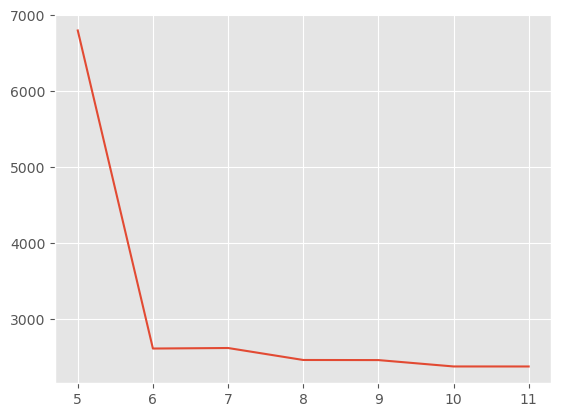

In [291]:
plt.plot(sparsity_vals,lin_loss_vals)
# plt.yscale('log')

In [306]:
opt = MIOSR(target_sparsity=7,alpha = 0.0,unbias = True)
new_theta = opt.fit(reduced_J,reduced_rhs[:,None]).coef_[0]

model.print(new_theta.reshape(model.theta.shape))

(x)' = -11.177 x + 10.924 y
(y)' = 23.365 x + -0.871 x z
(z)' = -2.833 z + 1.032 x y


In [233]:
opt.fit(reduced_J,reduced_rhs[:,None])

model.print(opt.coef_[0].reshape(model.theta.shape))

(x)' = -9.913 x + 9.999 y
(y)' = 27.889 x + -1.020 y + -0.993 x z
(z)' = -2.660 z + 1.006 x y


array([[ -0.93015906,   0.28503426,   0.        ],
       [-10.00524803,  27.70553027,   0.        ],
       [ 10.10658395,  -0.99936108,   0.        ],
       [  0.        ,   0.        ,  -2.66626801],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.00569569],
       [  0.        ,  -0.98750798,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ]])

In [131]:
from pysindy import EnsembleOptimizer
import numpy as np
t_grid = jnp.linspace(0,tend,500)
xdot = model.traj_model.derivative(t_grid,model.z)
x = model.predict_state(t_grid)
A = model.dynamics_model.feature_map(x)
opt = SSR(max_iter = 100,alpha = 0.00,criteria='coefficient_value',kappa = 20.)
opt = MIOSR(target_sparsity = 7)
base_opt = STLSQ(threshold = 0.25,alpha = 0.01,unbias = True)
opt = EnsembleOptimizer(base_opt,bagging = True,n_models = 100,n_subset = 10,
                        ensemble_aggregator = lambda x:np.mean(x,axis=0)
)

opt.fit(A,xdot)

,opt,STLSQ(alpha=0...hreshold=0.25)
,bagging,True
,library_ensemble,False
,n_models,100
,n_subset,10
,n_candidates_to_drop,1
,replace,True
,ensemble_aggregator,<function <la...x7f24efe74400>
,threshold,0.25
,alpha,0.01
,max_iter,20


In [132]:
opt.coef_list

[array([[ -0.93010248, -10.00502531,  10.10641724,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.28490677,  27.70453073,  -0.99907796,   0.        ,
           0.        ,   0.        ,  -0.98748061,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,  -2.66627611,
           0.        ,   1.00569935,   0.        ,   0.        ,
           0.        ,   0.        ]]),
 array([[ -0.93015381, -10.00504566,  10.10642153,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ],
        [  0.        ,  24.01951935,   0.        ,   0.        ,
           0.        ,   0.        ,  -0.87792242,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ,  -2.6662712 ,
           0.        ,   1.00570038,   0.        ,   0.        ,
           0.        ,   0. 

In [116]:
np.percentile(np.linspace(0,1,100),1.)

np.float64(0.01)

In [120]:
model.print(opt.coef_.T)

(x)' = -0.930 1 + -10.005 x + 10.106 y
(y)' = 0.285 1 + 27.705 x + -0.999 y + -0.987 x z
(z)' = -2.666 z + 1.006 x y


In [106]:
# import numpy as np
# from pysindy import SR3
# thresholds = np.linspace(0,1.2,500)
# results = []
# residuals = []
# recovered = []
# for t in thresholds:
# 	opt = STLSQ(threshold = t,alpha = 0.01,unbias = True)
# 	_ = opt.fit(A,xdot)
# 	residual = np.linalg.norm(A@opt.coef_.T - xdot)/np.linalg.norm(xdot)
# 	residuals.append(residual)
# 	results.append(np.linalg.norm(opt.coef_ - expdata.true_coeff))
# 	recovered.append(np.all(np.sign(opt.coef_) == np.sign(expdata.true_coeff)))
	

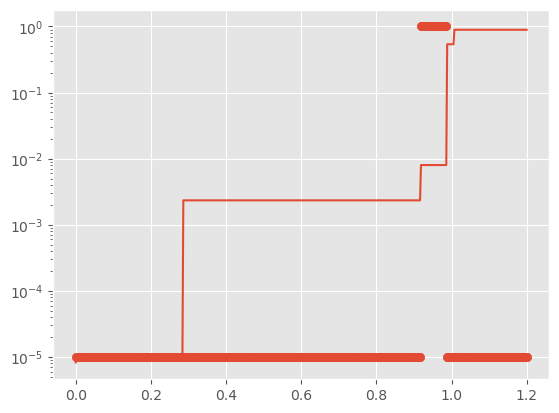

In [104]:
plt.plot(thresholds,residuals)
plt.scatter(thresholds,np.array(recovered)+1e-5)

plt.yscale('log')

In [6]:
expdata.print()

(x)' = -10.000 x + 10.000 y
(y)' = 28.000 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y
